In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

import PIL
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
import numpy as np
import pandas as pd
import copy
import time
import cv2 as cv
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg

import torchvision.transforms.functional as TF

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
test = '/content/drive/MyDrive/test_images/'
device = 'cuda'

In [5]:
class ImageData(Dataset):
    def __init__(self,is_train=False):
        self.transform = transforms.Compose([transforms.ToTensor(),])
        self.crop = transforms.Resize((218,178))
    def __len__(self):
        return (len(img_list)+1) - 1
    def __getitem__(self, index):
        img = mpimg.imread(img_dir+img_list[index])
        img = img.astype(np.uint8)
        img = self.crop(TF.to_pil_image(img))
        img = img.convert('RGB')
        img = self.transform(img)
        img = (img-0.5) /0.5

        return img

In [6]:
img_dir = test
img_list = os.listdir(img_dir)
num_images_to_show = len(img_list)
valid_dataset = ImageData()
batch_size = num_images_to_show
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_batch = next(iter(valid_dataloader)).to(device)

In [7]:
len(test_batch)

10

In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
IMG_WIDTH = 178
IMG_HEIGHT = 218
latent_size = 200

In [10]:
# Encoder Model
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        # ENCODER

        # 64x64x64
        self.e_conv_1 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5, 5), stride=(2, 2)),nn.LeakyReLU()
        )

        # 128x32x32
        self.e_conv_2 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), stride=(2, 2)),
            nn.LeakyReLU()
        )
        
        # 128x32x32
        self.e_block_1 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x32x32
        self.e_block_2 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x32x32
        self.e_block_3 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 32x32x32
        self.e_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=num_channels_in_encoder, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.Tanh()
        )
    def forward(self, x):
        ec1 = self.e_conv_1(x)
        ec2 = self.e_conv_2(ec1)
        eblock1 = self.e_block_1(ec2) + ec2
        eblock2 = self.e_block_2(eblock1) + eblock1
        eblock3 = self.e_block_3(eblock2) + eblock2
        ec3 = self.e_conv_3(eblock3)  # in [-1, 1] from tanh activation
        return ec3

In [11]:
# Encoder Model
class Encoder(nn.Module):
    def __init__(self,num_channels_in_encoder):
        super(Encoder, self).__init__()
        
        # ENCODER

        # 64x64x64
        self.e_conv_1 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5, 5), stride=(2, 2)),nn.LeakyReLU()
        )

        # 128x32x32
        self.e_conv_2 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), stride=(2, 2)),
            nn.LeakyReLU()
        )
        
        # 128x32x32
        self.e_block_1 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x32x32
        self.e_block_2 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x32x32
        self.e_block_3 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 32x32x32
        self.e_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=num_channels_in_encoder, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.Tanh()
        )
    def forward(self, x):
        ec1 = self.e_conv_1(x)
        ec2 = self.e_conv_2(ec1)
        eblock1 = self.e_block_1(ec2) + ec2
        eblock2 = self.e_block_2(eblock1) + eblock1
        eblock3 = self.e_block_3(eblock2) + eblock2
        ec3 = self.e_conv_3(eblock3)  # in [-1, 1] from tanh activation
        return ec3

In [12]:
device

'cuda'

In [13]:
# Generator / Decoder Model

class Generator(nn.Module):
    def __init__(self,num_channels_in_encoder):
        super(Generator, self).__init__()
        
        # DECODER

        # 128x64x64
        self.d_up_conv_1 = nn.Sequential(
        nn.Conv2d(in_channels=num_channels_in_encoder, out_channels=64, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=(2, 2), stride=(2, 2))
        )

        # 128x64x64
        self.d_block_1 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x64x64
        self.d_block_2 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x64x64
        self.d_block_3 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 256x128x128
        self.d_up_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.ConvTranspose2d(in_channels=32, out_channels=128, kernel_size=(2, 2), stride=(2, 2))
        )

        # 3x128x128
        self.d_up_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ReflectionPad2d((3, 3, 3, 3)),
            nn.Conv2d(in_channels=16, out_channels=3, kernel_size=(3, 3), stride=(1, 1)),
            nn.Tanh()
        )

        
        
    def forward(self, x):
        uc1 = self.d_up_conv_1(x)
        dblock1 = self.d_block_1(uc1) + uc1
        dblock2 = self.d_block_2(dblock1) + dblock1
        dblock3 = self.d_block_3(dblock2) + dblock2
        uc2 = self.d_up_conv_2(dblock3)
        dec = self.d_up_conv_3(uc2)
        return dec

In [14]:
num_channels_in_encoder = 40
netG40 = Generator(num_channels_in_encoder).to(device)
netG40.apply(weights_init)

num_channels_in_encoder = 40
netE40 = Encoder(num_channels_in_encoder).to(device)
netE40.apply(weights_init)

netG40.load_state_dict(torch.load("/content/netG40.model"))
netE40.load_state_dict(torch.load("/content/netE40.model"))


netE40.eval()
netG40.eval()
output = netE40(test_batch)
print(output.shape)
print("Compressed Image Size is: "+str((output.shape[1]*output.shape[2]*output.shape[3])/(test_batch.shape[1]*test_batch.shape[2]*test_batch.shape[3]))+" times the original image")

test_40 = netG40(netE40(test_batch))

del netE40
del netG40
torch.cuda.empty_cache()

torch.Size([10, 40, 54, 44])
Compressed Image Size is: 0.8164106793114112 times the original image


In [15]:
num_channels_in_encoder = 28
netE28 = Encoder(num_channels_in_encoder).to(device)
netE28.apply(weights_init)

num_channels_in_encoder = 28
netG28 = Generator(num_channels_in_encoder).to(device)
netG28.apply(weights_init)

netG28.load_state_dict(torch.load("/content/netG28.model"))
netE28.load_state_dict(torch.load("/content/netE28.model"))


netE28.eval()
netG28.eval()

output = netE28(test_batch)
print(output.shape)
print("Compressed Image Size is: "+str((output.shape[1]*output.shape[2]*output.shape[3])/(test_batch.shape[1]*test_batch.shape[2]*test_batch.shape[3]))+" times the original image")

test_28 = netG28(netE28(test_batch))

del netE28
del netG28
torch.cuda.empty_cache()

torch.Size([10, 28, 54, 44])
Compressed Image Size is: 0.5714874755179878 times the original image


In [16]:
num_channels_in_encoder = 16
netG16 = Generator(num_channels_in_encoder).to(device)
netG16.apply(weights_init)

num_channels_in_encoder = 16
netE16 = Encoder(num_channels_in_encoder).to(device)
netE16.apply(weights_init)

netG16.load_state_dict(torch.load("/content/netG16.model"))
netE16.load_state_dict(torch.load("/content/netE16.model"))


netE16.eval()
netG16.eval()

output = netE16(test_batch)
print(output.shape)
print("Compressed Image Size is: "+str((output.shape[1]*output.shape[2]*output.shape[3])/(test_batch.shape[1]*test_batch.shape[2]*test_batch.shape[3]))+" times the original image")

test_16 = netG16(netE16(test_batch))

del netE16
del netG16
torch.cuda.empty_cache()

torch.Size([10, 16, 54, 44])
Compressed Image Size is: 0.3265642717245645 times the original image


In [17]:
num_channels_in_encoder = 8
netE8 = Encoder(num_channels_in_encoder).to(device)
netE8.apply(weights_init)


netG8 = Generator(num_channels_in_encoder).to(device)
netG8.apply(weights_init)


netG8.load_state_dict(torch.load("/content/netG8.model"))
netE8.load_state_dict(torch.load("/content/netE8.model"))


netG8.eval()
netE8.eval()

output = netE8(test_batch)
print(output.shape)
print("Compressed Image Size is: "+str((output.shape[1]*output.shape[2]*output.shape[3])/(test_batch.shape[1]*test_batch.shape[2]*test_batch.shape[3]))+" times the original image")

test_8 = netG8(netE8(test_batch))

del netE8
del netG8
torch.cuda.empty_cache()

torch.Size([10, 8, 54, 44])
Compressed Image Size is: 0.16328213586228224 times the original image


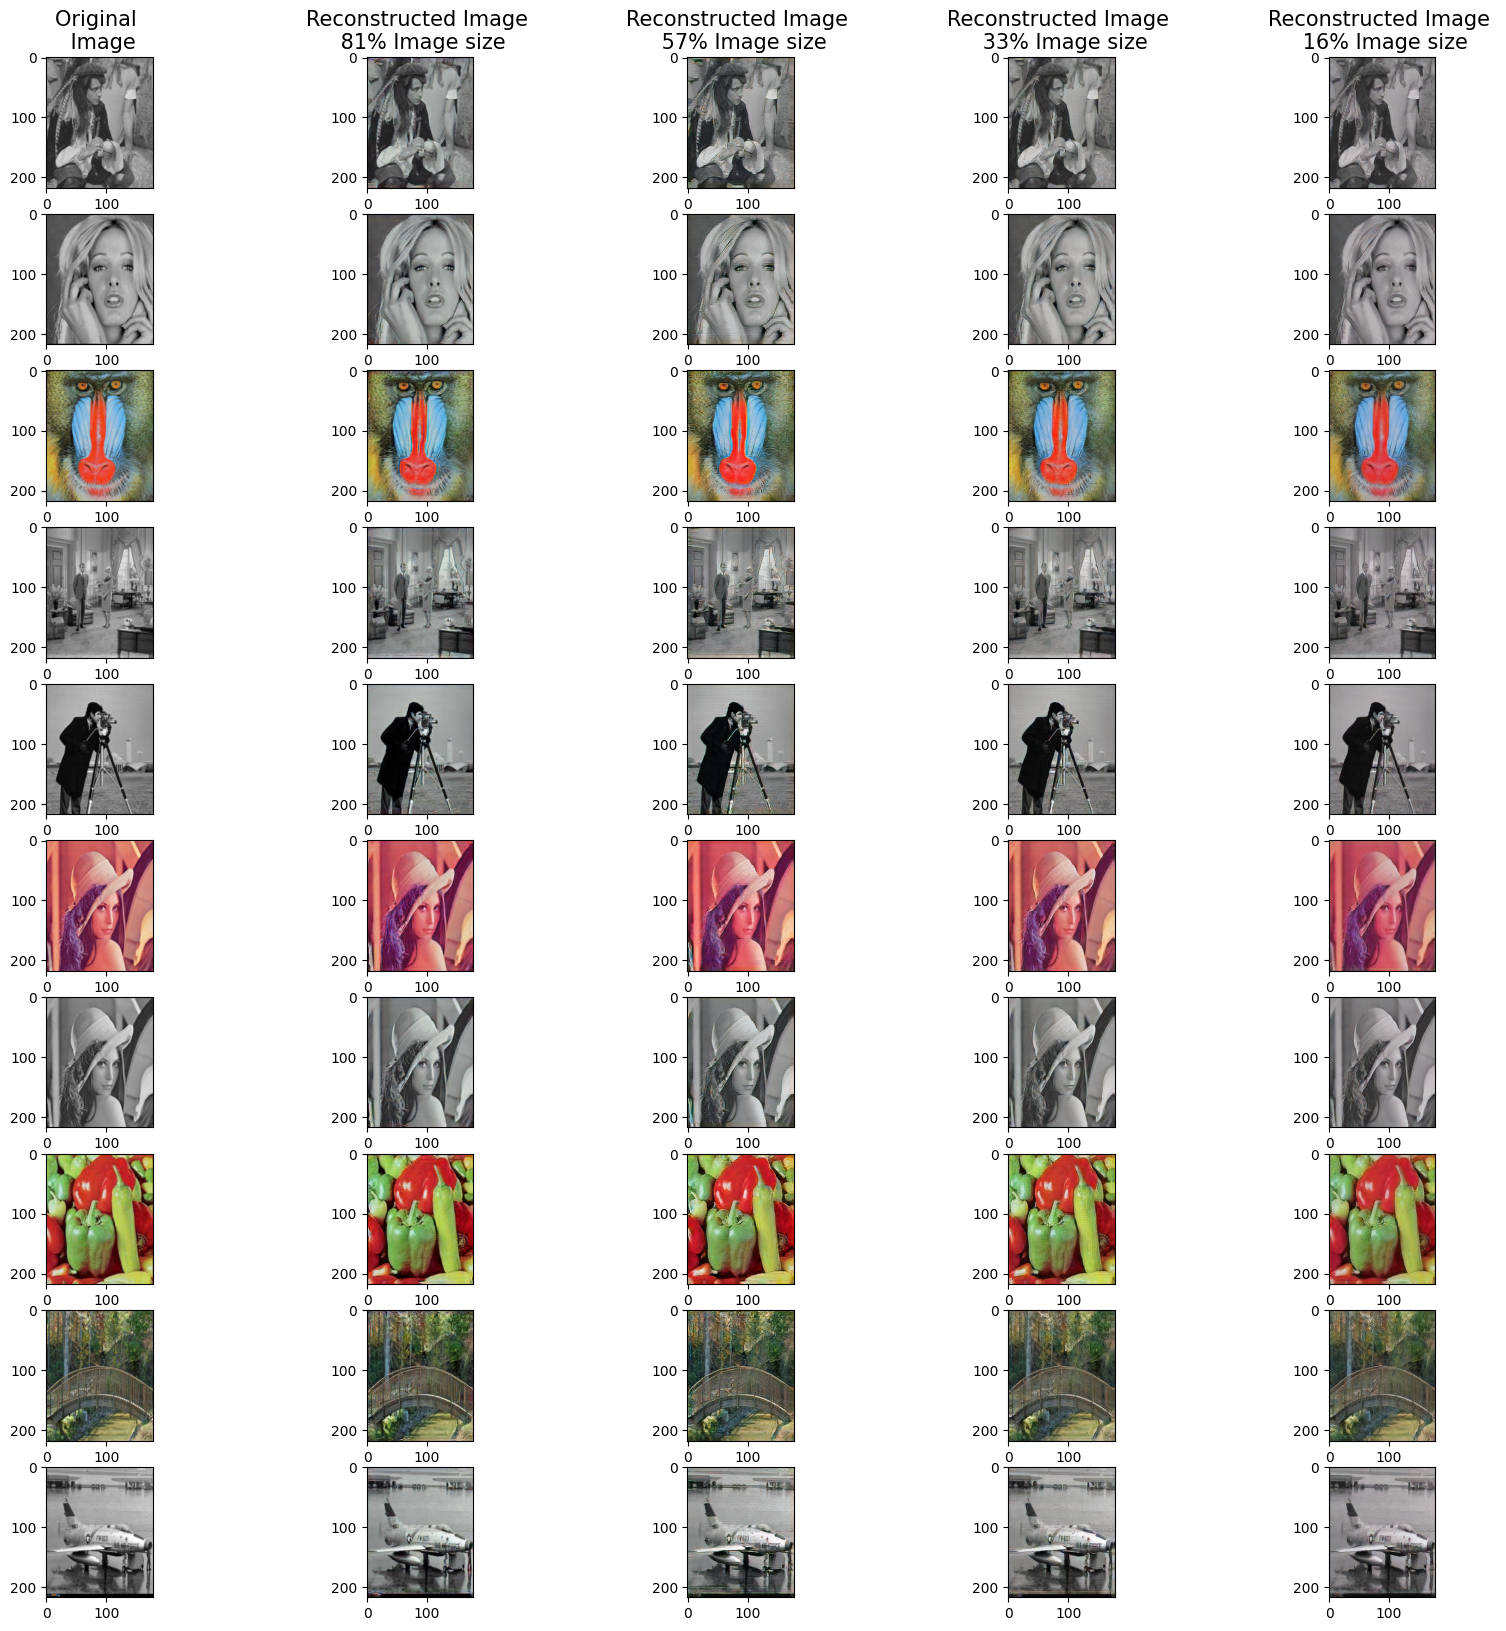

In [ ]:
##Plot the Reconstructed images by the Generator
f, axarr = plt.subplots(len(test_batch),5)

axarr[0,0].title.set_text('Original \n Image')
axarr[0,1].title.set_text('Reconstructed Image \n 81% Image size')
axarr[0,2].title.set_text('Reconstructed Image \n 57% Image size')
axarr[0,3].title.set_text('Reconstructed Image \n 33% Image size')
axarr[0,4].title.set_text('Reconstructed Image \n 16% Image size')

for i in range(5):
    axarr[0,i].title.set_fontsize(15)

for i in range(len(test_batch)):
    axarr[i,0].imshow(test_batch[i].cpu().detach().permute(1, 2, 0)*0.5+0.5)
    axarr[i,1].imshow(test_40[i].cpu().detach().permute(1, 2, 0)*0.5+0.5)
    axarr[i,2].imshow(test_28[i].cpu().detach().permute(1, 2, 0)*0.5+0.5)
    axarr[i,3].imshow(test_16[i].cpu().detach().permute(1, 2, 0)*0.5+0.5)
    axarr[i,4].imshow(test_8[i].cpu().detach().permute(1, 2, 0)*0.5+0.5)
    f.set_figheight(20)
    f.set_figwidth(20)
plt.show()

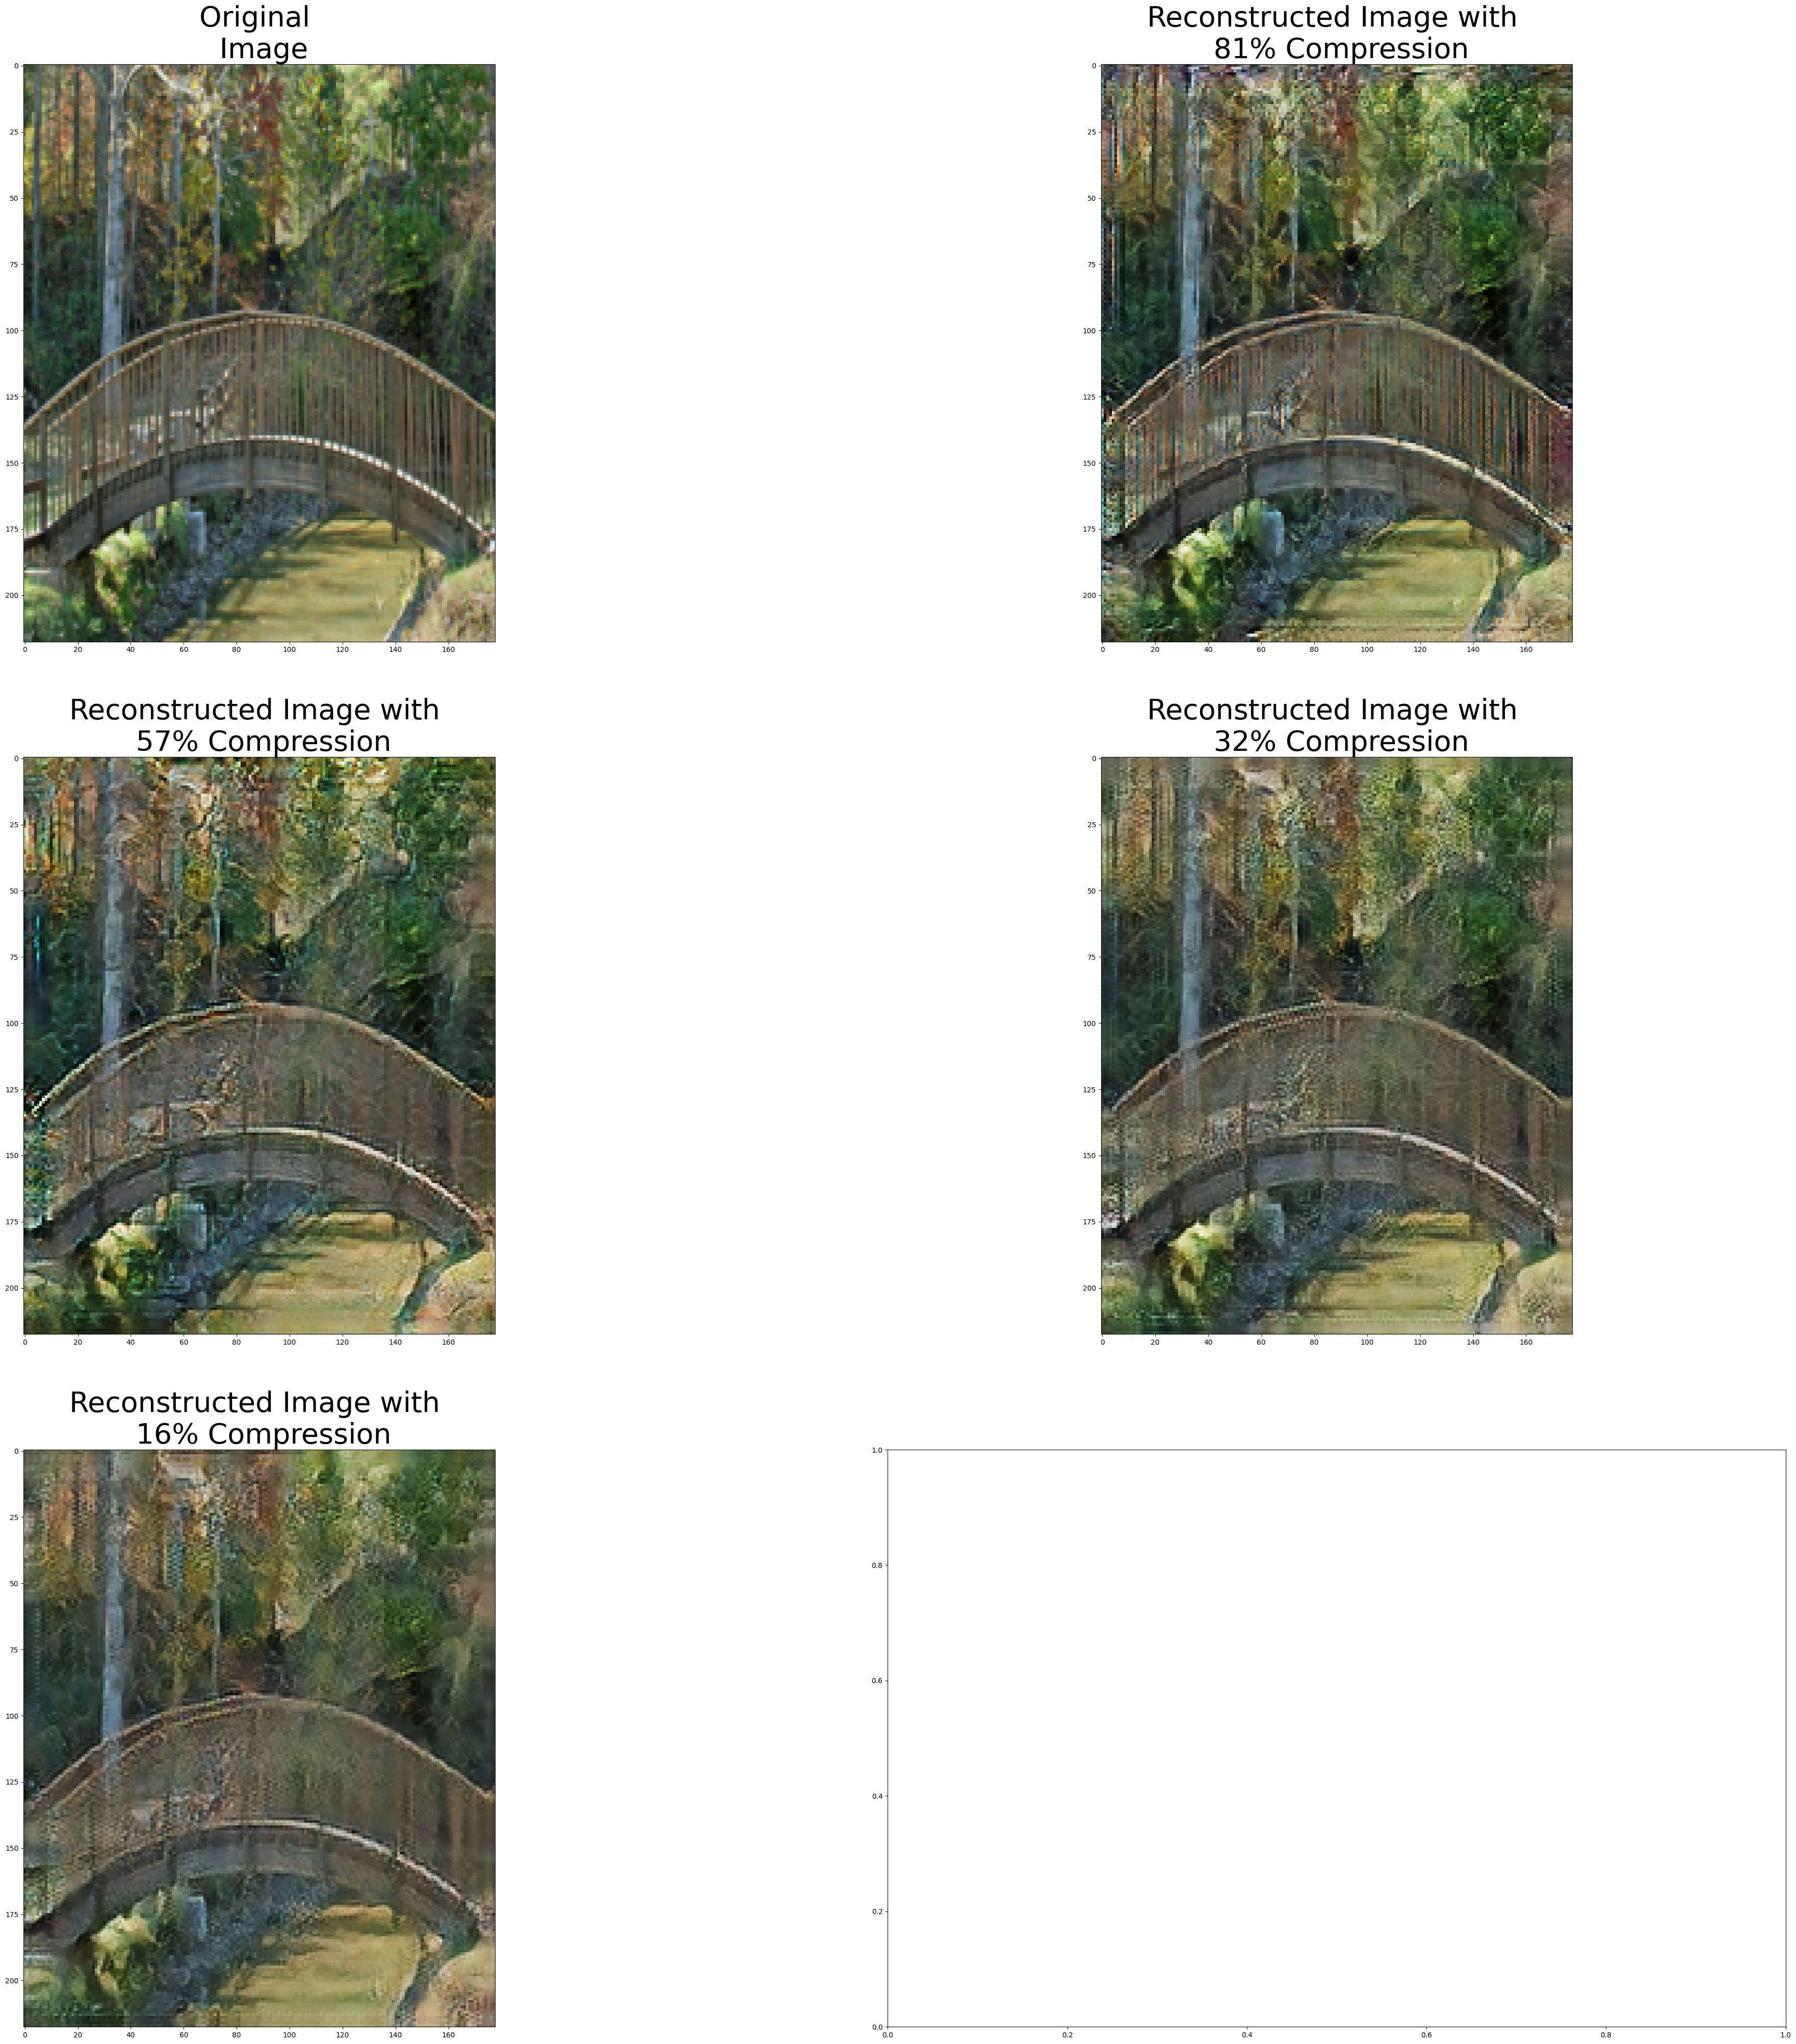

In [ ]:
##Plot a single image for better view
import random
f, axarr = plt.subplots(3,2)

axarr[0,0].title.set_text('Original \n Image')
axarr[0,1].title.set_text('Reconstructed Image with \n 81% Compression')
axarr[1,0].title.set_text('Reconstructed Image with \n 57% Compression')
axarr[1,1].title.set_text('Reconstructed Image with \n 32% Compression')
axarr[2,0].title.set_text('Reconstructed Image with \n 16% Compression')


for i in range(3):
    for j in range(2):
        axarr[i,j].title.set_fontsize(40)
i = random.randint(0,len(test_batch))


reimg = test_batch[i].cpu().detach().permute(1, 2, 0)*0.5+0.5
reimg_40 = test_40[i].cpu().detach().permute(1, 2, 0)*0.5+0.5
reimg_28 = test_28[i].cpu().detach().permute(1, 2, 0)*0.5+0.5
reimg_16 = test_16[i].cpu().detach().permute(1, 2, 0)*0.5+0.5
reimg_8 = test_8[i].cpu().detach().permute(1, 2, 0)*0.5+0.5



axarr[0,0].imshow(reimg)
axarr[0,1].imshow(reimg_40)
axarr[1,0].imshow(reimg_28)
axarr[1,1].imshow(reimg_16)
axarr[2,0].imshow(reimg_8)
f.set_figheight(50)
f.set_figwidth(50)
plt.show()

In [ ]:
##Calculating SSIM values
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

In [ ]:
reimg = reimg.view(1,reimg.shape[0],reimg.shape[1],reimg.shape[2])
reimg_28 = reimg_28.view(1,reimg_28.shape[0],reimg_28.shape[1],reimg_28.shape[2])
reimg_40 = reimg_40.view(1,reimg_40.shape[0],reimg_40.shape[1],reimg_40.shape[2])
reimg_16 = reimg_16.view(1,reimg_16.shape[0],reimg_16.shape[1],reimg_16.shape[2])
reimg_8 = reimg_8.view(1,reimg_8.shape[0],reimg_8.shape[1],reimg_8.shape[2])

In [ ]:
print("SSIM values for the above image:")
print("For 81% of image size: ",ssim(reimg, reimg_40).item())
print("For 57% of image size: ",ssim(reimg, reimg_28).item())
print("For 32% of image size: ",ssim(reimg, reimg_16).item())
print("For 16% of image size: ",ssim(reimg, reimg_8).item())

SSIM values for the above image:
For 81% of image size:  0.9455193281173706
For 57% of image size:  0.9282645583152771
For 32% of image size:  0.9453986883163452
For 16% of image size:  0.9504464268684387


In [ ]:
##Calculating PSNR values
from math import log10, sqrt
import numpy as np

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [ ]:
##Variables to store PSNR values to plot later
psnr40=[]
psnr28=[]
psnr16=[]
psnr8=[]
for i in range(len(test_batch)):
  psnr40.append(PSNR(((np.array(test_batch[i].cpu().detach().permute(1, 2, 0).clamp(0, 1)) * 255).astype(np.uint8)), (np.array(test_40[i].cpu().detach().permute(1, 2, 0).clamp(0, 1)) * 255).astype(np.uint8)))
  psnr28.append(PSNR(((np.array(test_batch[i].cpu().detach().permute(1, 2, 0).clamp(0, 1)) * 255).astype(np.uint8)), (np.array(test_28[i].cpu().detach().permute(1, 2, 0).clamp(0, 1)) * 255).astype(np.uint8)))
  psnr16.append(PSNR(((np.array(test_batch[i].cpu().detach().permute(1, 2, 0).clamp(0, 1)) * 255).astype(np.uint8)), (np.array(test_16[i].cpu().detach().permute(1, 2, 0).clamp(0, 1)) * 255).astype(np.uint8)))
  psnr8.append(PSNR(((np.array(test_batch[i].cpu().detach().permute(1, 2, 0).clamp(0, 1)) * 255).astype(np.uint8)), (np.array(test_8[i].cpu().detach().permute(1, 2, 0).clamp(0, 1)) * 255).astype(np.uint8)))

In [ ]:
##Variables to store unsqueezed tensor values to compute ssim
testOrg = []
test40 = []
test28 = []
test16 = []
test8 = []
for i in range(len(test_batch)):
  testOrg.append(test_batch[i].cpu().detach()*0.5+0.5)
  test40.append(test_40[i].cpu().detach()*0.5+0.5)
  test28.append(test_28[i].cpu().detach()*0.5+0.5)
  test16.append(test_16[i].cpu().detach()*0.5+0.5)
  test8.append(test_8[i].cpu().detach()*0.5+0.5)

In [ ]:
##Variables to store SSIM values to plot later
ssim40 = []
ssim28 = []
ssim16 = []
ssim8 = []
for i in range(len(test_batch)):
  testOrg[i] = testOrg[i].view(1,testOrg[i].shape[1],testOrg[i].shape[2],testOrg[i].shape[0])
  test40[i] = test40[i].view(1,test40[i].shape[1],test40[i].shape[2],test40[i].shape[0])
  test28[i] = test28[i].view(1,test28[i].shape[1],test28[i].shape[2],test28[i].shape[0])
  test16[i] = test16[i].view(1,test16[i].shape[1],test16[i].shape[2],test16[i].shape[0])
  test8[i] = test8[i].view(1,test8[i].shape[1],test8[i].shape[2],test8[i].shape[0])

for i in range(len(test_batch)):
  ssim40.append(ssim(testOrg[i], test40[i]).item())
  ssim28.append(ssim(testOrg[i], test28[i]).item())
  ssim16.append(ssim(testOrg[i], test16[i]).item())
  ssim8.append(ssim(testOrg[i], test8[i]).item())

In [ ]:
from tabulate import tabulate

In [ ]:
##Printing the PSNR results

data = []
for i in range(len(test_batch)):
  data.append(['Image'+str(i+1), psnr40[i], psnr28[i], psnr16[i], psnr8[i]])
col_names = ['IMAGE', 'PSNR-81% of image size', 'PSNR-57% of image size', 'PSNR-32% of image size', 'PSNR-16% of image size']
print(tabulate(data, headers=col_names))

IMAGE      PSNR-81% of image size    PSNR-57% of image size    PSNR-32% of image size    PSNR-16% of image size
-------  ------------------------  ------------------------  ------------------------  ------------------------
Image1                    32.9232                   32.242                    32.6495                   31.8754
Image2                    31.5742                   30.9163                   31.1234                   29.9834
Image3                    31.8683                   31.6569                   31.7465                   31.6693
Image4                    32.317                    31.5203                   31.9681                   31.3438
Image5                    32.0188                   31.7513                   31.5771                   30.0459
Image6                    32.4848                   32.1246                   32.3022                   31.3361
Image7                    33.0288                   31.9611                   32.5926                   

In [ ]:
##Printing the SSIM results

data1 = []
for i in range(len(test_batch)):
  data1.append(['Image'+str(i+1), ssim40[i], ssim28[i], ssim16[i], ssim8[i]])
col_names = ['IMAGE', 'SSIM-81% of image size', 'SSIM-57% of image size', 'SSIM-32% of image size', 'SSIM-16% of image size']
print(tabulate(data1, headers=col_names))

IMAGE      SSIM-81% of image size    SSIM-57% of image size    SSIM-32% of image size    SSIM-16% of image size
-------  ------------------------  ------------------------  ------------------------  ------------------------
Image1                   0.98703                   0.979837                  0.986148                  0.985804
Image2                   0.993558                  0.987444                  0.9918                    0.990265
Image3                   0.959501                  0.950785                  0.963144                  0.963386
Image4                   0.986064                  0.974567                  0.982685                  0.981187
Image5                   0.937652                  0.971469                  0.982861                  0.980064
Image6                   0.980605                  0.977673                  0.984018                  0.97736
Image7                   0.989426                  0.983943                  0.987849                  0.

In [ ]:
##Plotting PSNR and SSIM values along with images
f, axarr = plt.subplots(len(test_batch),5)

axarr[0,0].title.set_text('Original \n Image')
axarr[0,1].title.set_text('Reconstructed Image \n 81% Image size')
axarr[0,2].title.set_text('Reconstructed Image \n 57% Image size')
axarr[0,3].title.set_text('Reconstructed Image \n 33% Image size')
axarr[0,4].title.set_text('Reconstructed Image \n 16% Image size')

for i in range(5):
    axarr[0,i].title.set_fontsize(15)

for i in range(len(test_batch)):
    axarr[i,0].imshow(test_batch[i].cpu().detach().permute(1, 2, 0)*0.5+0.5)
    axarr[i,1].imshow(test_40[i].cpu().detach().permute(1, 2, 0)*0.5+0.5)
    axarr[i,2].imshow(test_28[i].cpu().detach().permute(1, 2, 0)*0.5+0.5)
    axarr[i,3].imshow(test_16[i].cpu().detach().permute(1, 2, 0)*0.5+0.5)
    axarr[i,4].imshow(test_8[i].cpu().detach().permute(1, 2, 0)*0.5+0.5)
    f.set_figheight(20)
    f.set_figwidth(20)
plt.show()

# x-axis values (e.g., image indices)
plt.figure(1)
x = []
for i in range(len(test_batch)):
  x.append('Image'+str(i+1))
plt.xticks(rotation=45, ha='right')
# Plotting
plt.plot(x, psnr40, label='81% of image size')
plt.plot(x, psnr28, label='57% of image size')
plt.plot(x, psnr16, label='32% of image size')
plt.plot(x, psnr8, label='16% of image size')

# Set labels and title
plt.xlabel('Image Index')
plt.ylabel('PSNR (dB)')
plt.title('PSNR for Different Compression Levels On Test Pictures')

# Display legend
plt.legend()

# Show the plot
plt.show()

plt.figure(2)
x.clear()
for i in range(len(test_batch)):
  x.append('Image'+str(i+1))
plt.xticks(rotation=45, ha='right')

# Plotting
plt.plot(x, ssim40, label='81% of image size')
plt.plot(x, ssim28, label='57% of image size')
plt.plot(x, ssim16, label='32% of image size')
plt.plot(x, ssim8, label='16% of image size')

# Set labels and title
plt.xlabel('Image Index')
plt.ylabel('SSIM')
plt.title('SSIM for Different Compression Levels On Test Pictures')

# Display legend
plt.legend()
# Show the plot
plt.show()